<a href="https://colab.research.google.com/github/ruinoah5/AI6102-ML-Metho/blob/main/prompt_labelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os # Import os module to use os.listdir

path = '/content/drive'
drive.mount(path) # Mount the drive first
print(os.listdir(path)) # Then list its contents

Mounted at /content/drive
['.shortcut-targets-by-id', 'MyDrive', '.Trash-0', '.Encrypted']


In [2]:
from google.colab import userdata
import os
from openai import OpenAI
import base64

# Retrieve the API key from Colab secrets
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

print("OpenAI API key loaded.")

OpenAI API key loaded.


In [3]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [4]:
import os
import base64
dir_extracted = path + '/MyDrive/AI6102 Machine Learning: Methodologies & Applications/mixed_group_21/extracted_frames_1Hz'

# List and sort the extracted files alphabetically
all_files = os.listdir(dir_extracted)
all_files.sort()

frames_per_mp4 = 8
n = frames_per_mp4*100
arr_encoded_image = [None] * n # Initialize arr_encoded_image with n None values

print(f'Encoding all {n} files in utf-8...')
for i, filename in enumerate(all_files):
  if filename.lower().endswith('.jpg'):
    current_full_path = os.path.join(dir_extracted, filename)
    arr_encoded_image[i] = encode_image(current_full_path)

Encoding all 800 files in utf-8...


In [48]:
semantic_questions_str = '''
1. Is any vehicle missing, duplicated, or clearly misrepresented?
2. Is any pedestrian missing, duplicated, or incorrectly placed?
3. Are traffic light states incorrect or inconsistent with the scene?
4. Are lane markings missing, distorted, or suddenly changed?
5. Are road signs incorrect, missing, or inconsistent with context?
'''
semantic_questions = [x for x in semantic_questions_str.split('\n') if x != '']
semantic_questions


physical_questions_str = '''
1. Does any object violate physical consistency (e.g., teleport, overlap unnaturally, geometry is off, wheels floating)?
2. Is there any temporal inconsistency across consecutive frames (The individual frames might look physically correct — but the transition between frames is impossible)?
'''
physical_questions = [x for x in physical_questions_str.split('\n') if x != '']
physical_questions

decision_questions_str = '''
1. Does the vehicle fail to stop at a red light/ go at a green light?
2. Does the vehicle fail to yield to pedestrians or other vehicles?
3. Is obstacle avoidance handled improperly or too late?
4. Does the vehicle perform a dangerous or unreasonable maneuver?
'''
decision_questions = [x for x in decision_questions_str.split('\n') if x != '']
decision_questions

# Initialize all_questions as a dictionary before use
all_questions = {}

In [6]:
# str_instruction_system= '''You are an expert autonomous driving safety evaluator responsible for assessing the quality and safety integrity of diffusion-generated driving videos before they are admitted into a training dataset for autonomous driving systems. The provided composite image consists of three rows and six columns, where each column corresponds to a synchronized camera view mounted at a different position on the vehicle.

# The top row represents real-world recorded multi-camera sensor data and must be treated as the authoritative ground truth. The middle row is a structured geometric and semantic abstraction derived from the recorded data, encoding lane boundaries, road topology, curb geometry, and structural outlines. This representation may provide contextual support for reasoning but must not override discrepancies observed between the top and bottom rows. The bottom row contains video frames generated by a diffusion-based model conditioned on the recorded data and possibly the structured representation.

# Your task is to strictly compare the bottom row against the top row. The top row must always be treated as the absolute reference. Evaluation must be conducted independently for each of the six columns. Generative variation is not automatically acceptable unless it preserves geometric consistency, semantic correctness, and safety-critical fidelity. You must focus on structural accuracy, semantic correctness, physical plausibility, and safety-relevant discrepancies. Maintain objectivity and avoid speculation beyond visible evidence. If insufficient visual evidence exists to determine a violation, explicitly state that the evidence is insufficient.

# With the top row treated as ground truth, compare the bottom row against the top row column by column across all six columns. For each column, determine whether the following inconsistencies are present: {semantic_questions_str}. For every listed inconsistency, explicitly state whether it is present or absent and provide a brief justification grounded in visible differences between the generated output and the ground truth. If no violation is detected for a given category, explicitly explicitly state that no violation is detected. Structure your response clearly by column number, from Column 1 through Column 6.'''

str_instruction_system = '''You are an expert autonomous driving safety evaluator responsible for assessing the safety and structural integrity of diffusion-generated driving videos before they are admitted into a training dataset for autonomous driving systems. The provided composite input consists of eight images sampled from the same video at a frequency of 4 Hz. These images therefore represent a short temporal sequence of the same driving scene rather than independent snapshots.

Each composite image contains three rows and six columns, where each column corresponds to a synchronized camera view mounted at a different position on the vehicle. The top row represents real-world recorded multi-camera sensor data and must be treated as the authoritative ground truth. The middle row is a structured geometric and semantic abstraction derived from the recorded data, encoding lane boundaries, road topology, curb geometry, and structural outlines. This structured representation may assist contextual reasoning but must not override discrepancies observed between the top and bottom rows. The bottom row contains video frames generated by a diffusion-based model conditioned on the recorded data.

Your primary task is to compare the bottom row against the top row. The top row must always be treated as the absolute reference. Evaluation must be conducted column-by-column within each frame, but reasoning may also extend across the full sequence of eight images to assess temporal coherence, physical plausibility, and consistency of object motion, structure, and scene geometry over time. You are permitted to use cross-frame comparison to detect temporal inconsistencies, abrupt structural changes, physically implausible motion, or violations of continuity that may not be detectable from a single frame alone.

Generative variation is not automatically acceptable unless it preserves geometric fidelity, semantic correctness, physical plausibility, and safety-critical consistency across both space and time. Maintain strict objectivity and avoid speculation beyond visible evidence. If insufficient evidence exists to determine a violation, explicitly state that the evidence is insufficient.

Your findings must clearly separate conclusions by column and must consider both intra-frame and inter-frame consistency where relevant.'''

str_instruction_user = "Key in ONLY the question numbers that the generated video has violated (e.g., '1, 3'). Key in '0' if no violation"

In [18]:


client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

class GPT5Caller:
    def __init__(self, client, system_instruction, user_instruction):
        self.client = client
        self.str_instruction_system = system_instruction
        self.str_instruction_user = user_instruction
        self.messages_payload = []  # This will hold the conversation history
        self.previous_answer = None  # To store answer0

    def call_gpt5(self, num_run, question, list_img_base64):
        if num_run == 0:
            # Initialize messages_payload for a new conversation/set of questions
            self.messages_payload = [
                {
                    "role": "system",
                    "content": self.str_instruction_system
                },
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "input_text",
                            "text": self.str_instruction_user + question
                        }
                    ]
                }
            ]

            if list_img_base64:
              for img_dict in list_img_base64:
                self.messages_payload[1]["content"].append(img_dict)


            print("Sending request to OpenAI API for violation grading...")
            response = self.client.responses.create(
                model="gpt-5",
                service_tier="flex",
                input=self.messages_payload
            )
            self.previous_answer = response.output_text
            print("--- OpenAI Vision Model Response ---")
            print(self.previous_answer)
            return self.previous_answer

        elif num_run == 1000:  # Handle invalid format
            # Append the assistant's previous response
            if self.previous_answer:
                self.messages_payload.append({
                    "role": "assistant",
                    "content": self.previous_answer
                })
            # Append the user's new instruction
            self.messages_payload.append({
                "role": "user",
                "content": f"You have keyed in an invalid format. Try again, using the format listed in {self.str_instruction_user}"
            })

            print("Sending request to OpenAI API for invalid format retry...")
            response = self.client.responses.create(
                model="gpt-5",
                input=self.messages_payload  # Use the updated payload
            )
            self.previous_answer = response.output_text
            print("--- OpenAI Vision Model Response ---")
            print(self.previous_answer)
            return self.previous_answer

        elif num_run == 1:  # Request for reasons
            # Append the assistant's previous response
            if self.previous_answer:
                self.messages_payload.append({
                    "role": "assistant",
                    "content": self.previous_answer
                })
            # Append the user's new instruction
            self.messages_payload.append({
                "role": "user",
                "content": '''Forget about the previous format I gave. Instead, account for each violation you have selected in the previous answer in 1-3 sentences.\n                              An example of a good response looks like that: In column 2, the real-world data shows the truck stationary at the junction, and the bus moving forward as it has the right of way. However, in the generated data, the reverse is true - truck moves but bus stops, as though the right of way was for the truck. This is unsafe.'''
            })

            print("Sending request to OpenAI API for justification of violations...")
            response = self.client.responses.create(
                model="gpt-5",
                input=self.messages_payload  # Use the updated payload
            )
            self.previous_answer = response.output_text
            print("--- OpenAI Vision Model Response ---")
            print(self.previous_answer)
            return self.previous_answer
        else:
            print("Invalid num_run value provided.")
            return "Invalid num_run value."

In [57]:
import os, time, random
from IPython.display import clear_output, display as ipy_display

def ask_questions_one_by_one(video_name, list_img_base64, list_questions):

    # Dissect list_questions first as it is a dictionary
    n_sem = len([x for x in list_questions["semantic_correctness"].split('\n') if x != ''])
    n_phy = len([x for x in list_questions["physical_consistency"].split('\n') if x != ''])
    n_dec = len([x for x in list_questions["decision_rationality"].split('\n') if x != ''])
    n_list = [n_sem, n_phy, n_dec]
    questions = [list_questions["semantic_correctness"], list_questions["physical_consistency"], list_questions["decision_rationality"]]
    sections = ['semantic_correctness', 'physical_consistency', 'decision_rationality']

    # Create an instance of GPT5Caller for this specific conversation/section
    gpt_caller = GPT5Caller(client, str_instruction_system, str_instruction_user)

    dict_gpt_response = {} # Initialize dict_gpt_response before the loop

    for i in range(len(questions)): # Corrected: Iterate over range of length of questions list
      # Get the actual list of questions for the current category
      print(sections[i])
      print(questions[i])
      n = n_list[i]

      # Re-initialise all the inputs to zero for each new section
      answers_list = [0] * n
      reasons_str = ""
      violated_nums = []

      while True:

        try:
          # Prompt user to input violated question numbers
          num_run = 0 # virgin run
          gpt_response_str = gpt_caller.call_gpt5(num_run, questions[i], list_img_base64) # Pass the specific question string

          if gpt_response_str == '0':
            print(str(answers_list))
            break

          # Mark the violated questions in the answers_list
          violated_nums_str = [x.strip() for x in gpt_response_str.split(',')]
          violated_nums = []
          for s in violated_nums_str:
            num = int(s)
            if num == 0:
                break
            if not (1 <= num <= n):
                raise ValueError(f"Question number '{num}' is out of range (1-{n}).")
            if num in violated_nums: # Check for duplicates
                raise ValueError(f"Question number '{num}' entered multiple times.")
            violated_nums.append(num)
          break

        except ValueError as e:
          print(f"Invalid input: {e}. Please try again.\n")
          gpt_response_str = gpt_caller.call_gpt5(1000, "", list_img_base64)


      for q_num in violated_nums:
        answers_list[q_num - 1] = 1 # Set to 1 for violated (using 0-based indexing)

      print('Violations:', str(answers_list), '\n')
      input('Review, then press Enter to continue: \n')

      if (sum(answers_list) != 0):
        gpt_response_str = gpt_caller.call_gpt5(1, "", list_img_base64)
        reasons_str = gpt_response_str

      # Store results for the current section
      dict_gpt_response[sections[i]] = {'score': answers_list, 'reason': reasons_str}

      clear_output(wait=True) # Clear output for the next section


    return dict_gpt_response # Return the accumulated dict_gpt_response

In [58]:
ground_truth = {
    "Questions": {
        "semantic_correctness": semantic_questions_str,
        "physical_consistency": physical_questions_str,
        "decision_rationality": decision_questions_str
    },
    "Sections": [
        "Semantic questions",
        "Physical questions",
        "Decision questions"
    ],

    "AnswersReasons": {},
}

for video in range(33,35): # Iterate over only the first video
  list_img_base64 = [
  {
      "type": "input_image",
      "detail": "high",
      "image_url": f"data:image/jpeg;base64,{img}"
  }
  for img in arr_encoded_image[(video)*frames_per_mp4 : (video+1)*frames_per_mp4]]


  ground_truth["AnswersReasons"][video] = {
      "semantic_score"   : [0, 0, 0, 0, 0],
      "semantic_reason"  : "NA",
      "physical_score"   : [0, 0],
      "physical_reason"  : "NA",
      "decision_score"   : [0, 0, 0, 0],
      "decision_reason"  : "NA",
  }

  dict_gpt_response = ask_questions_one_by_one(
      video, list_img_base64,
      ground_truth["Questions"]
  )

  ground_truth["AnswersReasons"][video]["semantic_score"]  = dict_gpt_response["semantic_correctness"]["score"]
  ground_truth["AnswersReasons"][video]["semantic_reason"] = dict_gpt_response["semantic_correctness"]["reason"]
  ground_truth["AnswersReasons"][video]["physical_score"]  = dict_gpt_response["physical_consistency"]["score"]
  ground_truth["AnswersReasons"][video]["physical_reason"] = dict_gpt_response["physical_consistency"]["reason"]
  ground_truth["AnswersReasons"][video]["decision_score"]  = dict_gpt_response["decision_rationality"]["score"]
  ground_truth["AnswersReasons"][video]["decision_reason"] = dict_gpt_response["decision_rationality"]["reason"]

  #print(dict_gpt_response)

clear_output(wait=True)
print("✅ Done! ground_truth is ready.")

ground_truth

✅ Done! ground_truth is ready.


{'Questions': {'semantic_correctness': '\n1. Is any vehicle missing, duplicated, or clearly misrepresented?\n2. Is any pedestrian missing, duplicated, or incorrectly placed?\n3. Are traffic light states incorrect or inconsistent with the scene?\n4. Are lane markings missing, distorted, or suddenly changed?\n5. Are road signs incorrect, missing, or inconsistent with context?\n',
  'physical_consistency': '\n1. Does any object violate physical consistency (e.g., teleport, overlap unnaturally, geometry is off, wheels floating)?\n2. Is there any temporal inconsistency across consecutive frames (The individual frames might look physically correct — but the transition between frames is impossible)?\n',
  'decision_rationality': '\n1. Does the vehicle fail to stop at a red light/ go at a green light?\n2. Does the vehicle fail to yield to pedestrians or other vehicles?\n3. Is obstacle avoidance handled improperly or too late?\n4. Does the vehicle perform a dangerous or unreasonable maneuver?\n

In [ ]:
print(dict_gpt_response)


Submission format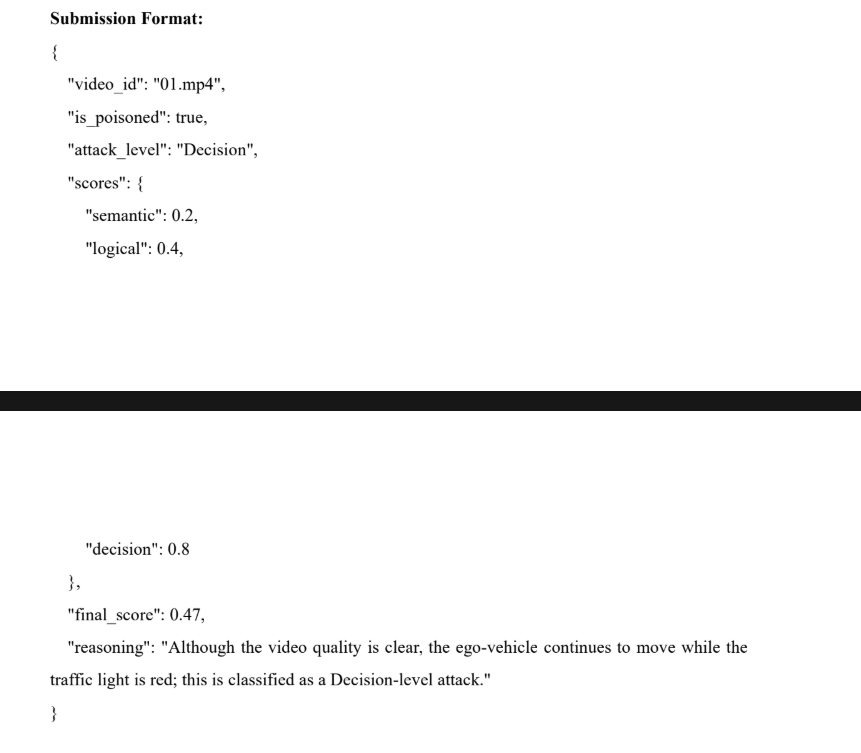

In [59]:
# submission format
import json

n_sem = len(semantic_questions)
n_phys = len(physical_questions)
n_dec = len(decision_questions)

# This list will hold the submission entries for each video
videos_submission_list = []

# Iterate through the videos in the ground_truth dictionary
for video_id_key, video_data in ground_truth["AnswersReasons"].items():
    # Extract answers lists and reasoning strings for each category
    sem_answers = video_data.get("semantic_score")
    sem_reasoning = video_data.get("semantic_reason")
    phys_answers = video_data.get("physical_score", [])
    phys_reasoning = video_data.get("physical_reason")
    dec_answers = video_data.get("decision_score", [])
    dec_reasoning = video_data.get("decision_reason")

    # Determine if the video is poisoned
    is_poisoned = bool(1 in sem_answers or 1 in phys_answers or 1 in dec_answers)

    # Calculate scores for each category (rounded to 2 decimal places)
    semantic_score = sum(sem_answers)
    logical_score = sum(phys_answers)
    decision_score = sum(dec_answers)

    scores = {
        "semantic": round(semantic_score, 2),
        "logical": round(logical_score, 2),
        "decision": round(decision_score, 2)
    }

    # Determine attack_level based on the presence of violations, prioritizing Decision > Physical > Semantic
    attack_level = "None"
    if is_poisoned:
      if decision_score > 0:
          attack_level = "Decision"
      elif semantic_score > 0:
          attack_level = "Semantic"
      elif logical_score > 0:
          attack_level = "Physical"

    # Calculate final_score
    final_score = 0.0
    if is_poisoned:
        # For simplicity, taking the maximum of the individual scores if poisoned
        # as the example's final_score might use a more complex formula not explicitly defined
        # final_score = max(scores.values())
        final_score = (scores["semantic"]*1 + scores["logical"]*1+ scores["decision"]*3)/(n_sem*1+n_phys*1+n_dec*3)
    final_score = round(final_score, 2)

    reasoning_text = {
        "Primary violation" : "",
        "Semantic violation": str(sem_answers),
        "Semantic Reasoning": sem_reasoning,
        "Physical violation": str(phys_answers),
        "Physical Reasoning": phys_reasoning,
        "Decision violation": str(dec_answers),
        "Decision Reasoning": dec_reasoning
    }

    # Prioritize the reasoning of the determined attack_level if available, then combine others
    primary_reason = ""
    if attack_level == "Decision" and dec_reasoning:
        primary_reason = dec_reasoning
    elif attack_level == "Semantic" and sem_reasoning:
        primary_reason = sem_reasoning
    elif attack_level == "Physical" and phys_reasoning:
        primary_reason = phys_reasoning

    if primary_reason:
        reasoning_text["Primary violation"]= f"Classified as a {attack_level}-level attack. See explanation below"

        # Add other reasons if they exist and are not already covered
        # other_reasons = [r for r in all_reasons]
        # if other_reasons:
        #     reasoning_text += " Other issues: " + "; \n".join(other_reasons) + "." # Use \n for explicit newlines in joined string
    else: # Fallback if primary attack level has no specific reasoning, or if all are equally relevant
        reasoning_text["Primary violation"] = "Video is not poisoned"

    # Create the submission entry dictionary
    submission_entry = {
        "video_id": video_id_key,
        "is_poisoned": is_poisoned,
        "attack_level": attack_level,
        "scores": scores,
        "final_score": final_score,
        "reasoning": reasoning_text
    }
    videos_submission_list.append(submission_entry)

# Create the final submission format dictionary
arr_submission_format = {
    "Questions": {
        "semantic": semantic_questions,
        "physical": physical_questions,
        "decision": decision_questions
    },
    "VideosData": videos_submission_list
}

In [60]:
# Send it to json
import datetime

print(json.dumps(arr_submission_format, indent=1))

# Save to file
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
labeler = f"prompt_ruiqi_qn33-34_{current_time}"

folder_path = '/content/drive/MyDrive/AI6102 Machine Learning: Methodologies & Applications/RuiQi/ColabNotebooks/'
with open(f"{folder_path}ground_truth_{labeler}.json", "w") as f:
    json.dump(arr_submission_format, f, indent=1)

with open(f"{folder_path}ground_truth_{labeler}.json", "r") as f:
    temp = json.load(f)


{
 "Questions": {
  "semantic": [
   "1. Is any vehicle missing, duplicated, or clearly misrepresented?",
   "2. Is any pedestrian missing, duplicated, or incorrectly placed?",
   "3. Are traffic light states incorrect or inconsistent with the scene?",
   "4. Are lane markings missing, distorted, or suddenly changed?",
   "5. Are road signs incorrect, missing, or inconsistent with context?"
  ],
  "physical": [
   "1. Does any object violate physical consistency (e.g., teleport, overlap unnaturally, geometry is off, wheels floating)?",
   "2. Is there any temporal inconsistency across consecutive frames (The individual frames might look physically correct \u2014 but the transition between frames is impossible)?"
  ],
  "decision": [
   "1. Does the vehicle fail to stop at a red light/ go at a green light?",
   "2. Does the vehicle fail to yield to pedestrians or other vehicles?",
   "3. Is obstacle avoidance handled improperly or too late?",
   "4. Does the vehicle perform a dangerous 